In [3]:
pip install seaborn

     -------------------------------------- 293.3/293.3 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [36]:
plt.rcParams['figure.figsize'] = (11.5, 8.5)

### Point wise

In [37]:
events_data = pd.read_csv('movie_events_linear.csv')
events_data.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Thriller,War,Western,price,ratings_average,ratings_count,release_date,unknown,outcome,user_id
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.283637,0.169532,-0.142869,0.393978,0.0,0,534
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.283637,-0.097012,-0.715191,0.393978,0.0,1,686
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,-0.777083,-1.056570,-0.690307,0.253620,0.0,1,532
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.246723,-0.416864,-0.690307,0.393978,0.0,1,624
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.344357,1.138281,-0.379263,0.464156,0.0,0,577


In [38]:
events_data.columns

Index(['Action', 'Adventure', 'Animation', 'Children's', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'price',
       'ratings_average', 'ratings_count', 'release_date', 'unknown',
       'outcome', 'user_id'],
      dtype='object')

Посчитаем число уникальных пользователей и среднее число фильмов на каждого в датасете

In [47]:
N_user = np.unique(events_data['user_id']).shape[0]
film_per_user = events_data.shape[0] / N_user
print('{} users, {} film'.format(N_user, film_per_user))

999 users, 20.0 film


Разобьем выборку на train и test.

In [48]:
X = events_data.drop('outcome', axis = 1)
y = events_data['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = events_data['user_id'])

In [49]:
X_train.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Sci-Fi,Thriller,War,Western,price,ratings_average,ratings_count,release_date,unknown,user_id
13309,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.283637,-0.097012,-0.715191,0.464156,0.0,389
12507,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.344357,1.182399,-0.727633,0.464156,0.0,635
9579,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-2.368163,-2.655833,-0.727633,0.604514,0.0,47
1346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.283637,-0.097012,-0.690307,0.323799,0.0,530
10154,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.813997,0.414753,0.317476,0.464156,0.0,494


Закодируем признак `user_id` с помощью OHE.
Используем `ColumnTransformer`.

In [50]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


column_transformer = ColumnTransformer([('user encoder', OneHotEncoder(), ['user_id'])], remainder = 'passthrough')
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

In [35]:
X_train

<13986x1022 sparse matrix of type '<class 'numpy.float64'>'
	with 94108 stored elements in Compressed Sparse Row format>

In [56]:
column_transformer.get_feature_names_out()

array(['user encoder__user_id_1', 'user encoder__user_id_2',
       'user encoder__user_id_3', ..., 'remainder__ratings_count',
       'remainder__release_date', 'remainder__unknown'], dtype=object)

Обучим логистическую регрессию.

In [57]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter = 2000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

Сделаем предсказание для теста и измерим качество с помощью Precision. 

In [60]:
from sklearn.metrics import precision_score

y_pred = lr.predict(X_test)
precision_score(y_test, y_pred)

0.6652812413410917

Просчитаем precision для каждого пользователя отдельно и усредним.

In [64]:
sum(X_test.toarray()[:,0] == 1) 

6

In [69]:
np.where(X_test.toarray()[:,0] == 1)[0]

array([ 510, 1170, 1266, 2202, 4577, 5336], dtype=int64)

In [77]:
y_test.values

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [75]:
pr = []
for i in range(N_user): # идем по колонкам пользователей и находим совпадения с 1
    ids = np.where(X_test.toarray()[:, i] == 1)[0]

    y_test_current = y_test.values[ids]
    y_pred_current = y_pred[ids]

    pr.append(precision_score(y_test_current, y_pred_current, zero_division = 0)) # zero_division - не выдает ошибки если мы не дали не один из фильмов пользователю

In [76]:
np.mean(pr)

0.6657657657657656

Для каждого пользователя выберем 3 самых 'уверенных' прогноза модели и посчитаем pr@3.

In [79]:
y_pred_probe = lr.predict_proba(X_test)[:,1]
y_pred_probe

array([0.42223345, 0.65243164, 0.91462194, ..., 0.6156139 , 0.34080952,
       0.4843809 ])

In [86]:
higher_ids = np.argsort(y_pred_probe)[-3:]
y_pred_probe[higher_ids]

array([0.98479881, 0.98763633, 0.98939781])

In [89]:
pr = []
for i in range(N_user):
    ids = np.where(X_test.toarray()[:, i] == 1)[0]

    #most confident predictions
    ps = y_pred_probe[ids]
    confident_ids = ids[np.argsort(ps)[-3:]]

    # precision@3

    y_test_current = y_test.values[confident_ids]
    y_pred_current = y_pred[confident_ids]
    pr.append(precision_score(y_test_current, y_pred_current, zero_division = 0))

In [90]:
np.mean(pr)

0.7013680347013681

---

# Pair wise

Используем данные о парах фильмах. Значение 1 целевой переменной означает, что был выбран фильм 1, а 0 - что фильм 2.

In [102]:
events_data = pd.read_csv('movie_events_pairwise-linear.csv')

In [103]:
events_data.head()

,Action_1,Adventure_1,Animation_1,Children's_1,Comedy_1,Crime_1,Documentary_1,Drama_1,Fantasy_1,Film-Noir_1,...,Thriller_2,War_2,Western_2,price_2,ratings_average_2,ratings_count_2,release_date_2,unknown_2,outcome,user_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.283637,-0.325478,-0.391705,0.604514,0.0,0.0,517.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.813997,0.268534,-0.478797,0.464156,0.0,1.0,155.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.777083,-0.378482,-0.117986,-1.430668,0.0,0.0,559.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.283637,0.060890,3.191525,0.534335,0.0,0.0,707.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,-2.368163,-2.655833,-0.727633,0.464156,0.0,0.0,73.0


In [104]:
events_data.columns

Index(['Action_1', 'Adventure_1', 'Animation_1', 'Children's_1', 'Comedy_1',
       'Crime_1', 'Documentary_1', 'Drama_1', 'Fantasy_1', 'Film-Noir_1',
       'Horror_1', 'Musical_1', 'Mystery_1', 'Romance_1', 'Sci-Fi_1',
       'Thriller_1', 'War_1', 'Western_1', 'price_1', 'ratings_average_1',
       'ratings_count_1', 'release_date_1', 'unknown_1', 'Action_2',
       'Adventure_2', 'Animation_2', 'Children's_2', 'Comedy_2', 'Crime_2',
       'Documentary_2', 'Drama_2', 'Fantasy_2', 'Film-Noir_2', 'Horror_2',
       'Musical_2', 'Mystery_2', 'Romance_2', 'Sci-Fi_2', 'Thriller_2',
       'War_2', 'Western_2', 'price_2', 'ratings_average_2', 'ratings_count_2',
       'release_date_2', 'unknown_2', 'outcome', 'user_id'],
      dtype='object')

In [105]:
events_data.shape

(130236, 48)

In [106]:
events_data['outcome'].value_counts()

0.0    65118
1.0    65118
Name: outcome, dtype: int64

In [107]:
print(np.unique(events_data['user_id']).shape)

print(events_data.shape[0]/np.unique(events_data['user_id']).shape[0])

(999,)
130.36636636636638


Разбиваем выборку на train и test, кодируем переменную user_id.

In [109]:
X = events_data.drop('outcome', axis = 1)
y = events_data['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = events_data['user_id'])

In [110]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((91165, 47), (39071, 47), (91165,), (39071,))

In [113]:
column_transformer = ColumnTransformer([('encoder', OneHotEncoder(), ['user_id'])], remainder = 'passthrough')
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

Обучаем логистическую регрессию.

In [114]:
lr = LogisticRegression(max_iter = 2000)

Делаем предсказание для теста, измеряем качество с помощью метрик из предыдущей части. Сравниваем результат.

In [116]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [118]:
precision_score(y_test, y_pred)

0.7125190839694656

In [122]:
Users = X_test.toarray()[:,:1000]

In [123]:
pr = []

for i in range(N_user):
    ids = np.where(Users[:,i] == 1)

    y_test_current = y_test.values[ids]
    y_pred_current = y_pred[ids]

    pr.append(precision_score(y_test_current, y_pred_current))

np.mean(pr)

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.7217645877660436

Выводим важности признаков

In [128]:
column_transformer.get_feature_names_out()

array(['encoder__user_id_1.0', 'encoder__user_id_2.0',
       'encoder__user_id_3.0', ..., 'remainder__ratings_count_2',
       'remainder__release_date_2', 'remainder__unknown_2'], dtype=object)

In [130]:
feature_importances = pd.DataFrame({'feature': column_transformer.get_feature_names_out(), 'importance': lr.coef_[0]})
feature_importances.iloc[:10]

,feature,importance
0,encoder__user_id_1.0,0.043466
1,encoder__user_id_2.0,-0.163141
2,encoder__user_id_3.0,0.083126
3,encoder__user_id_4.0,0.123144
4,encoder__user_id_5.0,-0.041113
5,encoder__user_id_6.0,-0.149376
6,encoder__user_id_7.0,0.085432
7,encoder__user_id_8.0,-0.105039
8,encoder__user_id_9.0,0.112427
9,encoder__user_id_10.0,-0.043525


In [131]:
feature_importances = feature_importances.sort_values('importance', ascending=False)
feature_importances.iloc[:10]

,feature,importance
1021,remainder__unknown_1,0.813069
468,encoder__user_id_469.0,0.646837
1040,remainder__price_2,0.573384
586,encoder__user_id_587.0,0.482188
1041,remainder__ratings_average_2,0.401775
726,encoder__user_id_727.0,0.387047
116,encoder__user_id_117.0,0.382421
146,encoder__user_id_147.0,0.378974
611,encoder__user_id_612.0,0.363708
51,encoder__user_id_52.0,0.354883


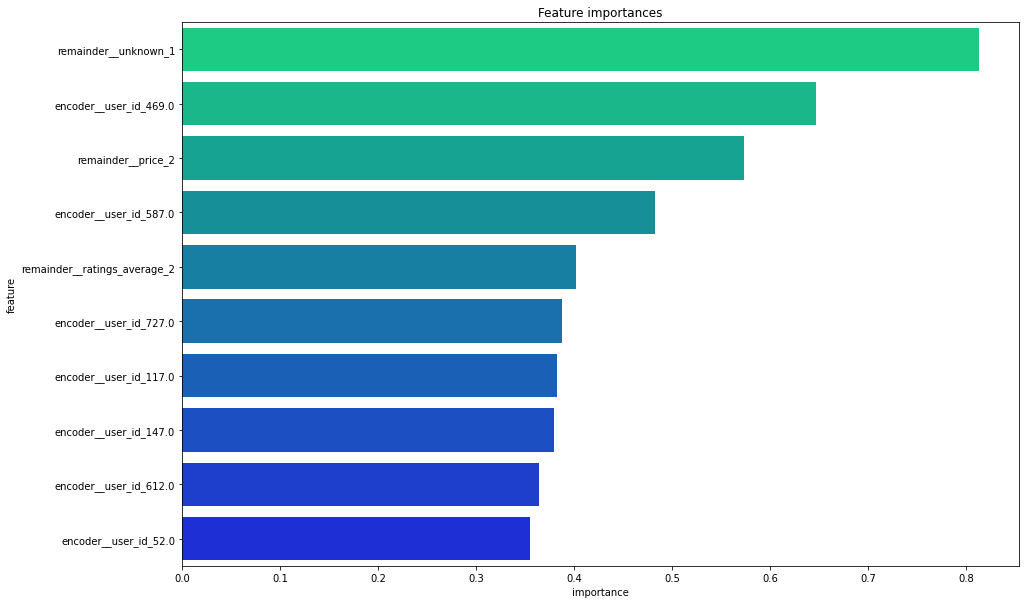

In [132]:
plt.figure(figsize=(15, 10))
sns.barplot(data=feature_importances[:10], x='importance', y='feature', palette="winter_r")
plt.title('Feature importances')
plt.show()

Делаем то же самое, но со случайным лесом.

In [133]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [134]:
y_pred = rf.predict(X_test)
precision_score(y_test, y_pred)

0.9471640265712826

In [135]:
pr = []

for i in range(N_user):
    ids = np.where(Users[:,i] == 1)

    y_test_current = y_test.values[ids]
    y_pred_current = y_pred[ids]

    pr.append(precision_score(y_test_current, y_pred_current))

np.mean(pr)

0.9429036730422719

In [136]:
rf.feature_importances_

array([6.40759816e-04, 2.29656742e-04, 4.44465249e-04, ...,
       5.07185667e-02, 4.61947930e-02, 4.02567780e-05])

In [138]:
feature_importances = pd.DataFrame({'feature': column_transformer.get_feature_names_out(), 'importance': rf.feature_importances_})
feature_importances

,feature,importance
0,encoder__user_id_1.0,0.000641
1,encoder__user_id_2.0,0.000230
2,encoder__user_id_3.0,0.000444
3,encoder__user_id_4.0,0.000476
4,encoder__user_id_5.0,0.000182
...,...,...
1040,remainder__price_2,0.073041
1041,remainder__ratings_average_2,0.082970
1042,remainder__ratings_count_2,0.050719
1043,remainder__release_date_2,0.046195


In [139]:
feature_importances = feature_importances.sort_values('importance', ascending=False)
feature_importances.iloc[:10]

,feature,importance
1018,remainder__ratings_average_1,0.084537
1041,remainder__ratings_average_2,0.082970
1040,remainder__price_2,0.073041
1017,remainder__price_1,0.071748
1042,remainder__ratings_count_2,0.050719
1019,remainder__ratings_count_1,0.050716
1020,remainder__release_date_1,0.046382
1043,remainder__release_date_2,0.046195
1029,remainder__Drama_2,0.008267
1026,remainder__Comedy_2,0.008179


In [142]:
usefull_features = []
for c in feature_importances['feature']:
    if not 'user' in c:
        usefull_features.append(c)

In [146]:
feature_importances_new = feature_importances.loc[feature_importances.feature.isin(usefull_features)]

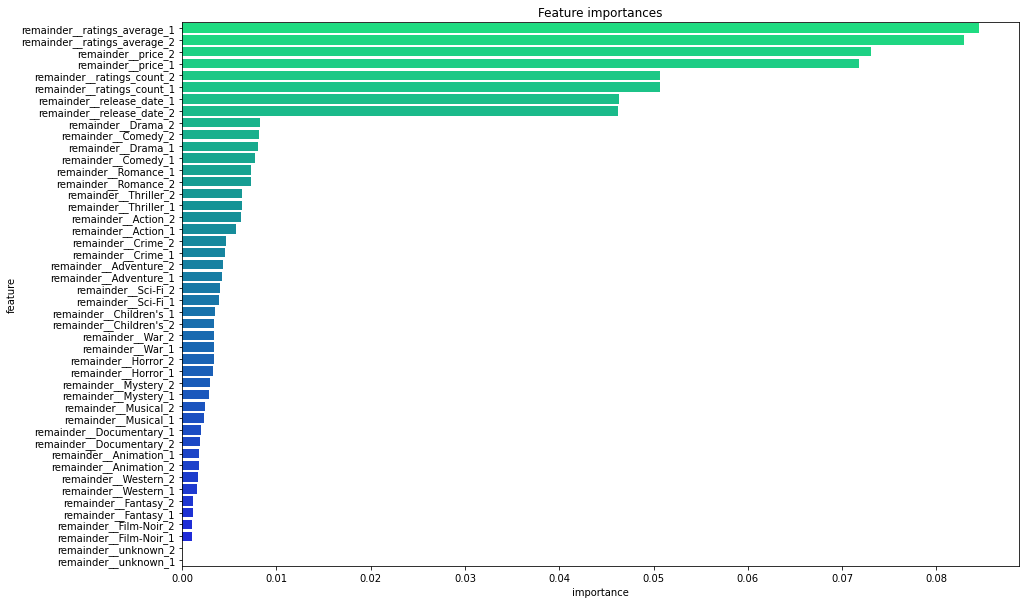

In [148]:
plt.figure(figsize=(15, 10))
sns.barplot(data=feature_importances_new, x='importance', y='feature', palette="winter_r")
plt.title('Feature importances')
plt.show()